In [1]:
import matplotlib
%matplotlib inline

import matplotlib.pyplot as plt
from IPython.display import display, clear_output

import os
import sys
import re
import time
import copy
import json
from collections import defaultdict
from tqdm import tqdm
from multiprocess import Pool

import numpy as np
import pandas as pd
import scipy.sparse
import scipy.spatial

In [2]:
def fig2data ( fig ):
    """
    @brief Convert a Matplotlib figure to a 4D numpy array with RGBA channels and return it
    @param fig a matplotlib figure
    @return a numpy 3D array of RGBA values
    Ref: http://www.icare.univ-lille1.fr/tutorials/convert_a_matplotlib_figure
    """
    # Get rid of the margins
    fig.gca().set_axis_off()
    fig.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                hspace = 0, wspace = 0)
    #fig.margins(0,0)
    from matplotlib.ticker import NullLocator
    fig.gca().xaxis.set_major_locator(NullLocator())
    fig.gca().yaxis.set_major_locator(NullLocator())
    
    # draw the renderer
    fig.canvas.draw ( )

    # Get the RGBA buffer from the figure
    w,h = fig.canvas.get_width_height()
    buf = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8).reshape((h, w, 3))
    #buf = buf.transpose((1, 0, 2))
    #buf = np.fromstring ( fig.canvas.tostring_argb(), dtype=np.uint8 )
    #buf.shape = ( w, h,4 )
    
    # canvas.tostring_argb give pixmap in ARGB mode. Roll the ALPHA channel to have it in RGBA mode
    #buf = np.roll ( buf, 3, axis = 2 )
    return buf

def frames2web(frames, fps=60):
    """Converts NxHxWxC NumPu array into Base64-encode video, wrapped in HTML (for Visdom visualization)"""
    import skvideo.io
    import tempfile
    import mimetypes
    import base64
    videofile = '/tmp/%s.mp4' % next(tempfile._get_candidate_names())
    skvideo.io.vwrite(videofile, frames,
                      inputdict={
                        "-r": "%d" % fps
                      },
                      outputdict={
                        "-b": "4000000"
                      })

    extension = videofile[-3:].lower()
    mimetypes = dict(mp4='mp4', ogv='ogg', avi='avi', webm='webm')
    mimetype = mimetypes.get(extension)

    with open(videofile, 'rb') as f:
        bytestr = f.read()
    videodata = """
        <video width="%d" controls>
            <source type="video/%s" src="data:video/%s;base64,%s">
            Your browser does not support the video tag.
        </video>
    """ % (frames.shape[2]*1.5, mimetype, mimetype, base64.b64encode(bytestr).decode('utf-8'))
    return videodata

from IPython.display import HTML


from visdom import Visdom
viz = Visdom()
viz_opts = {
    'sim_slice': dict()
}
viz_windows = { k: None for k in viz_opts.keys() }
# vizdom .video() modified to use scikit-video instead of OpenCV
def viz_video(frames, win=None, env=None, opts=None, fps=60):
    return viz.text(text=frames2web(frames, fps), win=win, env=env, opts=opts)

In [51]:
n_aux_p = 3
env_p = [
  'aminoacids',
#     'atp',
]
cell_p = [
  'genome',
  'x',
  'y',
  'aminoacids',
  'atp',
  'cycle',
]
for i in np.arange(n_aux_p):
  env_p.append('aux{0}'.format(i))
  cell_p.append('aux{0}'.format(i))
env_p_map = {k:v for v, k in enumerate(env_p)}
cell_p_map = {k:v for v, k in enumerate(cell_p)}

# env2cell_p = {cell_p_map[k] for k, v in env_p_map if k in cell_p_map}
# cell2env_p = {env_p_map[k] for k, v in cell_p_map if k in env_p_map}
# for i in np.arange(n_aux_p):
#   env2cell_p[len(env_p) + i] = len(cell_p) + i
#   cell2env_p[len(cell_p) + i] = len(env_p) + i

resource_cost = {
  cell_p_map['cycle']: 1.0,
}
for i, p in enumerate(cell_p[-n_aux_p:]):
  resource_cost[cell_p_map[p]] = 0.01 / (i + 1)

cell2cell_diffusion = {
  cell_p_map['aminoacids']: 0.2,
  cell_p_map['atp']: 0.2,
}
env2cell_diffusion = {
  'aminoacids': 0.05,
#     'atp': 0.05,
}
for i, p in enumerate(env_p[-n_aux_p:]):
  env2cell_diffusion[p] = 0.1 / (i + 1)
  
cell2env_diffusion = {
  #
}
for i, p in enumerate(cell_p[-n_aux_p:]):
  cell2env_diffusion[p] = 0.1 / (n_aux_p - i)


def simulate(args):
  import os
  import sys
  import re
  import time
  import copy
  import json
  from collections import defaultdict
  from tqdm import tqdm
  from multiprocess import Pool

  import numpy as np
  import pandas as pd
  import scipy.sparse
  import scipy.spatial

  env_p, env_p_map, cell_p, cell_p_map, resource_cost, cell2cell_diffusion, env2cell_diffusion, cell2env_diffusion, genomes, genes, gene_cell_map, cells, reactions, env, ground_level, steps = args
  sim_speed = 0.25
  
  
  def interp_weights(x, y):
    xf, xi = np.modf(x)
    yf, yi = np.modf(y)
    xi = xi.astype(np.int32)
    yi = yi.astype(np.int32)
    w = np.array([
      [xf * yf, xf * (1-yf)],
      [(1-xf) * yf, (1-xf) * (1-yf)],
    ])
    return w, xi, yi

  def interp_bilinear(a, x, y):
    w, xi, yi = interp_weights(x, y)
    w = np.expand_dims(w, -1)
    return a[xi, yi] * w[0, 0] \
      + a[xi, yi+1] * w[0, 1] \
      + a[xi+1, yi] * w[1, 0] \
      + a[xi+1, yi+1] * w[1, 1]

  def add_interp_bilinear(a, x, y, val):
    w, xi, yi = interp_weights(x, y)
    w = np.expand_dims(w, -1)
  #   print(val.shape)
  #   print(a[xi, yi].shape)
  #   print(w[0, 0].shape)
    a[xi, yi] += w[0, 0] * val
    a[xi, yi+1] += w[0, 1] * val
    a[xi+1, yi] += w[1, 0] * val
    a[xi+1, yi+1] += w[1, 1] * val
    return a

  def sub_interp_bilinear(a, x, y, val):
    w, xi, yi = interp_weights(x, y)
    w = np.tile(np.expand_dims(w, -1), (1, val.shape[1]))

    # Re-weight by the available resource amounts
    w[0, 0] *= a[xi, yi]
    w[0, 1] *= a[xi, yi+1]
    w[1, 0] *= a[xi+1, yi]
    w[1, 1] *= a[xi+1, yi+1]
    w /= (np.sum(w, axis=(0,1), keepdims=True) + 1e-6)

    a[xi, yi] -= w[0, 0] * val
    a[xi, yi+1] -= w[0, 1] * val
    a[xi+1, yi] -= w[1, 0] * val
    a[xi+1, yi+1] -= w[1, 1] * val
    return a


  cell_history = []
  env_history = []
  cell_tree = None
  last_neighbour_update = 0
  neighbour_update_interval = 4
#   cell_steps = [[] for _ in np.arange(cells.shape[0])]
#   print('Simulating..')
  for step in tqdm(np.arange(steps), disable=True):
    # Refill the earth
    env[:, :ground_level, env_p_map['aminoacids']] = np.minimum(env[:, :ground_level, env_p_map['aminoacids']] + 0.004, 1.0)

    # Sunlight
#     env[:, (ground_level-1):, env_p_map['atp']] = np.minimum(env[:, (ground_level-1):, env_p_map['atp']] + 0.1, 1.0)

    # Env -> cell diffusion
    for pname, v in env2cell_diffusion.items():
      diff_amount = np.minimum(
        np.minimum(
          np.maximum(1.0 - cells[:, cell_p_map[pname]], 0.0), 
          interp_bilinear(env, cells[:, cell_p_map['x']], cells[:, cell_p_map['y']])[:, env_p_map[pname]]
        ),
        v
      )
#       print(diff_amount)
#       print(np.sum(np.where(env < 0, env, 0.0)))
      cells[:, cell_p_map[pname]] += diff_amount
      resource_d = np.zeros((cells.shape[0], env.shape[-1]))
      resource_d[:, env_p_map[pname]] = diff_amount
      env = sub_interp_bilinear(env, cells[:, cell_p_map['x']], cells[:, cell_p_map['y']], resource_d)
        
    # Cell -> env diffusion
    for pname, v in cell2env_diffusion.items():
      diff_amount = np.minimum(
        np.minimum(
          cells[:, cell_p_map[pname]], 
          np.maximum(1.0 - interp_bilinear(env, cells[:, cell_p_map['x']], cells[:, cell_p_map['y']])[:, env_p_map[pname]], 0.0)
        ),
        v
      )
#       print(diff_amount)
#       print(np.sum(np.where(env < 0, env, 0.0)))
      cells[:, cell_p_map[pname]] -= diff_amount
      resource_d = np.zeros((cells.shape[0], env.shape[-1]))
      resource_d[:, env_p_map[pname]] = diff_amount
      env = add_interp_bilinear(env, cells[:, cell_p_map['x']], cells[:, cell_p_map['y']], resource_d)

    # Express genes
    for gene_idx, gene in enumerate(genes):
      if gene_idx not in gene_cell_map:
        continue
        
      cell_subset = gene_cell_map[gene_idx]
        
      def cell_subset_idx(cell_subset, p):
        if isinstance(p, list):
          return tuple([np.tile(cell_subset, len(p)), np.repeat(p, len(cell_subset))])
        return tuple([np.tile(cell_subset, 1), np.repeat([p], len(cell_subset))])
        
      expression = np.ones((len(cell_subset)))
      # Apply activator influence on expression
      if len(gene['activators']) > 0:
        expression *= 1e-6
#         print(cells[cell_subset_idx(cell_subset, gene['activators'])])
        expression += np.prod(cells[cell_subset_idx(cell_subset, gene['activators'])], axis=-1)
      # Apply repressor influence on expression
      if len(gene['repressors']) > 0:
#         print(cells[cell_subset_idx(cell_subset, gene['repressors'])])
        expression -= np.sum(cells[cell_subset_idx(cell_subset, gene['repressors'])], axis=-1)
      expression = np.maximum(expression, 0.0) * sim_speed
      # Limit expression by the amount of materials and energy available
      expression = np.minimum(expression, cells[cell_subset][:, cell_p_map['aminoacids']] / resource_cost[gene['product']] * sim_speed)
      expression = np.minimum(expression, cells[cell_subset][:, cell_p_map['atp']] / resource_cost[gene['product']] * sim_speed)
#       print(expression)
      cells[cell_subset_idx(cell_subset, gene['product'])] += expression
      cells[cell_subset_idx(cell_subset, cell_p_map['aminoacids'])] -= expression * resource_cost[gene['product']]
      cells[cell_subset_idx(cell_subset, cell_p_map['atp'])] -= expression * resource_cost[gene['product']]

    # Process reactions inside the cells
    # TODO: make sure resource amounts do not become negative
    for reaction in reactions:
#       reaction_power = np.expand_dims(np.minimum(np.min(cells[:, list(reaction['reactants'].keys())] / np.array(list(reaction['reactants'].values())), axis=1), 1.0), -1)
      reaction_power = np.expand_dims(
        np.minimum(
          np.prod(cells[:, list(reaction['reactants'].keys())] / np.array(list(reaction['reactants'].values())), axis=1), 
          np.min(cells[:, list(reaction['reactants'].keys())] / np.array(list(reaction['reactants'].values())), axis=1)
        ), 
        -1
      )
      cells[:, list(reaction['reactants'].keys())] = np.maximum(cells[:, list(reaction['reactants'].keys())] - np.array(list(reaction['reactants'].values())) * reaction_power * sim_speed, 0.0)
      cells[:, list(reaction['products'].keys())] += np.array(list(reaction['products'].values())) * reaction_power * sim_speed
      
    # TODO: Variable resource decay?
    resource_decay = 0.99
    cells[:, cell_p_map['cycle']+1:] *= resource_decay

    for ic in np.arange(cells.shape[0]):
      # Absorb sunlight
      cell_r = 0.5
      if cells[ic, cell_p_map['y']] >= ground_level-1 and not np.any((cells[:, cell_p_map['y']] > cells[ic, cell_p_map['y']]) & (np.abs(cells[:, cell_p_map['x']] - cells[ic, cell_p_map['x']]) < cell_r)):
        cells[ic, cell_p_map['atp']] += 0.1 * sim_speed
    
    # Consume resources to stay alive
    cells[:, cell_p_map['atp']] -= 0.001 * sim_speed
    cells[:, cell_p_map['aminoacids']] -= 0.001 * sim_speed
    starving = np.where((cells[:, cell_p_map['atp']] <= 0.0) | (cells[:, cell_p_map['aminoacids']] <= 0.0))
#     print(cells.shape)
#     print(starving)
    had_divisions = False
    if len(starving[0]) > 0:
      cells = np.delete(cells, starving[0], axis=0)
      had_divisions = True
      # Rebuild the gene-cell mapping
      gene_cell_map = {}
      for cell_idx, genome_id in enumerate(cells[:, cell_p_map['genome']]):
        for gene_id in genomes[int(genome_id)]['genes']:
          if gene_id not in gene_cell_map:
            gene_cell_map[gene_id] = []
          gene_cell_map[gene_id].append(cell_idx)
#     print(cells.shape) 
        
    # Grow up
#     cells[np.argmax(cells[:, cell_p_map['y']]), cell_p_map['cycle']] += 0.5 * sim_speed
      
    next_cells = np.copy(cells)
    
    for ic in np.arange(cells.shape[0]):
      # Divide cells
      if cells[ic, cell_p_map['cycle']] >= 1.0:
        new_cell = np.zeros((len(cell_p), ))
        new_cell[cell_p_map['genome']] = cells[ic, cell_p_map['genome']]
        new_cycle = (cells[ic, cell_p_map['cycle']] - 1.0) / 2.0
        # Position the new cell randomly around the parent
        new_cell[cell_p_map['x']] = np.clip(cells[ic, cell_p_map['x']] + np.clip(np.random.randn(), -3.0, 3.0) / 3.0, 0.5, env.shape[0] - 1.5)
        new_cell[cell_p_map['y']] = np.clip(cells[ic, cell_p_map['y']] + np.clip(np.random.randn(), -3.0, 3.0) / 3.0, 0.5, env.shape[1] - 1.5)
        # All resources are split semi-equally (up to 10% difference)
        resource_diff = 0.05 * np.clip(np.random.randn(*cells[ic, cell_p_map['aminoacids']:].shape) / 3.0, -1.0, 1.0) * cells[ic, cell_p_map['aminoacids']:] / 2.0
        new_cell[cell_p_map['aminoacids']:] = cells[ic, cell_p_map['aminoacids']:] / 2.0 + resource_diff
        next_cells[ic, cell_p_map['aminoacids']:] = cells[ic, cell_p_map['aminoacids']:] / 2.0 - resource_diff
        next_cells[ic, cell_p_map['cycle']] = new_cycle
        new_cell[cell_p_map['cycle']] = new_cycle
        next_cells = np.concatenate([next_cells, [new_cell]], axis=0)
        had_divisions = True
#         print('genes')
#         print(genomes[int(new_cell[cell_p_map['genome']])]['genes'])
        for gene_id in genomes[int(new_cell[cell_p_map['genome']])]['genes']:
#           print(gene_id)
          gene_cell_map[gene_id].append(next_cells.shape[0] - 1)
#         cell_steps.append([])
  #       print(cells)

#       max_dist = 2.0
#       max_neighbours = 6
#       neighbour_dist_l1 = np.abs(cells[:, cell_p_map['x']] - cells[ic, cell_p_map['x']]) + np.abs(cells[:, cell_p_map['y']] - cells[ic, cell_p_map['y']])
#       neighbour_dist_l1[ic] = sys.float_info.max
#       neighbours = list(map(
#         lambda x: x[0], 
#         sorted(
#           filter(lambda x: x[1] < max_dist, enumerate(neighbour_dist_l1)), 
#           key=lambda x: x[1]
#         )
#       ))[:max_neighbours]
# #       neighbour_check = (np.abs(cells[:, cell_p_map['x']] - cells[ic, cell_p_map['x']]) < max_dist) & (np.abs(cells[:, cell_p_map['y']] - cells[ic, cell_p_map['y']]) < max_dist)
# #       neighbour_check[ic] = False
# #       neighbours = np.where(neighbour_check)[0]

#       move_vec = np.zeros((2))
#       for ine in neighbours:
#         dirv = np.array([cells[ine, cell_p_map['x']] - cells[ic, cell_p_map['x']], cells[ine, cell_p_map['y']] - cells[ic, cell_p_map['y']]])
#         dist = np.sqrt(np.power(dirv[0], 2) + np.power(dirv[1], 2))
#         diffusion_dist = 1.0
#         if dist < diffusion_dist:
#           # Cell -> cell diffusion
#           for p, v in cell2cell_diffusion.items():
#             diff_amount = (cells[ic, p] - cells[ine, p]) / 2.0 * v
#   #           diff_amount = min(
#   #             np.abs((cells[ic, p] - cells[ine, p]) / 2.0), 
#   #             v
#   #           ) * np.sign(cells[ic, p] - cells[ine, p])
#             next_cells[ic, p] = np.maximum(next_cells[ic, p] - diff_amount * sim_speed, 0.0)
#             next_cells[ine, p] = np.maximum(next_cells[ine, p] + diff_amount * sim_speed, 0.0)

#         # Neighbour attraction/repulsion
#         move_vec += dirv * (np.power(max(dist-1.0, 0), 1.5) * 0.2 - 2.0*np.power(1 - min(dist / 1.0, 1), 0.5)) * 0.4

#       # Cell movement
#       move_vec = np.clip(move_vec * 0.5 * sim_speed, -1.0, 1.0)
#       next_cells[ic, cell_p_map['x']] = np.clip(next_cells[ic, cell_p_map['x']] + move_vec[0], 0.5, env.shape[0] - 1.5)
#       next_cells[ic, cell_p_map['y']] = np.clip(next_cells[ic, cell_p_map['y']] + move_vec[1], 0.5, env.shape[1] - 1.5)

#       cell_steps[ic].append((step, np.copy(next_cells[ic])))
    
    if cell_tree is None or had_divisions or last_neighbour_update + neighbour_update_interval <= step:
      cell_tree = scipy.spatial.KDTree(next_cells[:, cell_p_map['x']:(cell_p_map['y']+1)])
      max_dist = 2.0
      neighbours = cell_tree.query_pairs(max_dist, p=2)  # cells[:, cell_p_map['x']:cell_p_map['y']], 6
      last_neighbour_update = step
    
    neighbours = np.array(list(neighbours))
    
    if neighbours.shape[0] > 0:
      dirv = np.array([next_cells[neighbours[:, 1], cell_p_map['x']] - next_cells[neighbours[:, 0], cell_p_map['x']], next_cells[neighbours[:, 1], cell_p_map['y']] - next_cells[neighbours[:, 0], cell_p_map['y']]]).T
      dist = np.sqrt(np.power(dirv[:, 0], 2) + np.power(dirv[:, 1], 2))
      dirv = dirv / (np.linalg.norm(dirv, axis=1, keepdims=True) + 1e-6)
      diffusion_dist = 1.0
      diffusors = np.argwhere(dist < diffusion_dist)
#       for p, v in cell2cell_diffusion.items():
#         diff_amount = (cells[ic, p] - cells[ine, p]) / 2.0 * v
#       if dist < diffusion_dist:
      if diffusors.shape[0] > 0:
        # Cell -> cell diffusion
        for p, v in cell2cell_diffusion.items():
          diff_amount = (next_cells[neighbours[diffusors, 1], p] - next_cells[neighbours[diffusors, 0], p]) / 2.0 * v
  #           diff_amount = min(
  #             np.abs((cells[ic, p] - cells[ine, p]) / 2.0), 
  #             v
  #           ) * np.sign(cells[ic, p] - cells[ine, p])
          np.add.at(next_cells, (neighbours[diffusors, 0], p), diff_amount * sim_speed)
          np.add.at(next_cells, (neighbours[diffusors, 1], p), -diff_amount * sim_speed)
          next_cells[:, p] = np.maximum(next_cells[:, p], 0.0)

#       move_force = 0.1 * (np.power(dist, 0.1) - 0.8 * np.power(1.0 / np.maximum(dist - 0.5, 0.1), 1.5))
      move_force = (np.power(np.maximum(dist-1.0, 0), 1.5) * 0.2 - 2.0*np.power(1 - np.minimum(dist / 1.0, 1), 0.5)) * 0.1
#       move_force = (np.power(np.maximum(dist-1.0, 0), 1.5) * 0.2 - 2.0*np.power(1 - np.minimum(dist / 1.0, 1), 0.5)) * 0.4
    # Neighbour attraction/repulsion
#     move_vec += dirv * (np.power(max(dist-1.0, 0), 1.5) * 0.2 - 2.0*np.power(1 - min(dist / 1.0, 1), 0.5)) * 0.4

      move_vec = np.zeros((next_cells.shape[0], 2))
      np.add.at(move_vec, (neighbours[:, 0], 0), dirv[:, 0] * move_force)
      np.add.at(move_vec, (neighbours[:, 0], 1), dirv[:, 1] * move_force)
      np.add.at(move_vec, (neighbours[:, 1], 0), -dirv[:, 0] * move_force)
      np.add.at(move_vec, (neighbours[:, 1], 1), -dirv[:, 1] * move_force)
#       move_vec = move_vec / np.expand_dims(np.maximum(np.bincount(neighbours.ravel(), minlength=move_vec.shape[0]), 1.0).astype(np.float32), -1)
      move_vec = np.clip(move_vec, -1.0, 1.0) * sim_speed
      move_vec += np.clip(np.random.randn(*move_vec.shape) / 3.0, -1.0, 1.0) * 0.1 * move_vec

    # Cell movement
#     move_vec = np.clip(move_vec * 0.5 * sim_speed, -1.0, 1.0)
      next_cells[:, cell_p_map['x']:(cell_p_map['y']+1)] += move_vec
#       next_cells[neighbours[:, 0], cell_p_map['x']] += dirv[:, 0] * move_force * sim_speed
#       next_cells[neighbours[:, 0], cell_p_map['y']] += dirv[:, 1] * move_force * sim_speed
#       next_cells[neighbours[:, 1], cell_p_map['x']] -= dirv[:, 0] * move_force * sim_speed
#       next_cells[neighbours[:, 1], cell_p_map['y']] -= dirv[:, 1] * move_force * sim_speed
      next_cells[:, cell_p_map['x']] = np.clip(next_cells[:, cell_p_map['x']], 0.5, env.shape[0] - 1.5)
      next_cells[:, cell_p_map['y']] = np.clip(next_cells[:, cell_p_map['y']], 0.5, env.shape[1] - 1.5)

    cells = next_cells
    if step % 10 == 0:
      cell_history.append(np.copy(cells))
      env_history.append(np.copy(env))
      
  return cell_history, env_history

  # fix, ax = plt.subplots(len(cell_steps), figsize=(10, 18), sharex=True)
  # plot_map = {
  #   'cycle': '#44cccc',
  #   'aminoacids': '#997744',
  #   'atp': '#cccc44',
  # }
  # for ic in np.arange(len(cell_steps)):
  #   for pname, color in plot_map.items():
  #     ax[ic].plot(list(map(lambda x: x[0], cell_steps[ic])), list(map(lambda x: x[1][cell_p_map[pname]], cell_steps[ic])), color=color)

def render(cell_history, env_history):
  def show_frame(cells, env):
    fig, ax = plt.subplots(figsize=(6, 2))
    ax.fill_between([0, env.shape[0]], 0, ground_level-1, alpha=.4)
    ax.plot(0, 0, alpha=0)
    ax.plot(env.shape[0], env.shape[1], alpha=0)
#     ax.scatter(cells[:, cell_p_map['x']], cells[:, cell_p_map['y']], s=20, c=np.array(list(map(lambda x: '#%02x%02x%02x' % tuple(((np.array([0.2, 0.2, 0.2]) + min(x, 1.0) * np.array([0.0, 0.8, 0.8])) * 250).astype(np.int32)), cells[:, cell_p_map['cycle']]))))
    cmap = plt.cm.get_cmap('Set2')
    ax.scatter(cells[:, cell_p_map['x']], cells[:, cell_p_map['y']], s=20, c=np.array(list(map(lambda x: '#%02x%02x%02x' % tuple(((np.array([0.0, 0.0, 0.0]) + min(max(x[cell_p_map['cycle']], 0.0), 1.0) * np.array(cmap(x[cell_p_map['genome']] % 20)[:3])) * 250).astype(np.int32)), cells[:]))))
#     ax.set_title('Cycle')
    f1 = fig2data(fig)
    plt.close()

    fig2, ax = plt.subplots(figsize=(6, 2))
    env_img = np.zeros((env.shape[0], env.shape[1], 3))
    env_img[:, ground_level:, :] = 1.0
    env_img[:, :ground_level, :] = np.array([0.4, 0.4, 0.0]) + np.minimum(env[:, :ground_level, env_p_map['aminoacids']:env_p_map['aminoacids']+1], 1.0) * np.array([0.6, 0.6, 0.0])
    ax.imshow(env_img.transpose((1, 0, 2)), interpolation='bilinear', origin='lower')  # , extent=(50-0.5, (env.shape[0] - 50)-0.5, 50-0.5, (env.shape[1] - 50)-0.5)
    ax.plot(0, 0, alpha=0)
    ax.plot(env.shape[0], env.shape[1], alpha=0)
    ax.scatter(cells[:, cell_p_map['x']], cells[:, cell_p_map['y']], s=20, c=np.array(list(map(lambda x: '#%02x%02x%02x' % tuple(((np.array([0.2, 0.2, 0.2]) + min(x, 1.0) * np.array([0.8, 0.0, 0.8])) * 250).astype(np.int32)), cells[:, cell_p_map['aminoacids']]))))
#     ax.set_title('Earth energy')
    f2 = fig2data(fig2)
    plt.close()

    fig3, ax = plt.subplots(figsize=(6, 2))
    ax.fill_between([0, env.shape[0]], 0, ground_level-1, alpha=.4)
    ax.plot(0, 0, alpha=0)
    ax.plot(env.shape[0], env.shape[1], alpha=0)
    ax.scatter(cells[:, cell_p_map['x']], cells[:, cell_p_map['y']], s=20, c=np.array(list(map(lambda x: '#%02x%02x%02x' % tuple(((np.array([0.2, 0.2, 0.2]) + min(x, 1.0) * np.array([0.8, 0.8, 0.0])) * 250).astype(np.int32)), cells[:, cell_p_map['atp']]))))
#     ax.set_title('Sun energy')
    f3 = fig2data(fig3)
    plt.close()
    
    faux = []
    for i in np.arange(3):
      fig, ax = plt.subplots(figsize=(6, 2))
      env_img = np.zeros((env.shape[0], env.shape[1], 3))
      env_img = np.array([1.0, 1.0, 1.0]) - np.minimum(env[:, :, (len(env_p) - n_aux_p + i):(len(env_p) - n_aux_p + i)+1], 1.0) * np.array([0.8, 0.8, 0.0])
      ax.imshow(env_img.transpose((1, 0, 2)), interpolation='bilinear', origin='lower')
#       ax.fill_between([0, env.shape[0]], 0, ground_level-1, alpha=.4)
      ax.plot(0, 0, alpha=0)
      ax.plot(env.shape[0], env.shape[1], alpha=0)
      ax.scatter(cells[:, cell_p_map['x']], cells[:, cell_p_map['y']], s=20, c=np.array(list(map(lambda x: '#%02x%02x%02x' % tuple(((np.array([0.2, 0.2, 0.2]) + min(x, 1.0) * np.array([0.8, 0.8, 0.0])) * 250).astype(np.int32)), cells[:, len(cell_p) - n_aux_p + i]))))
  #     ax.set_title('Sun energy')
      f = fig2data(fig)
      plt.close()
      faux.append(f)
    
    return np.concatenate([
      np.concatenate([f1, f2, f3], axis=0),
      np.concatenate(faux, axis=0),
    ], axis=1)

  frames = []
  print('Rendering figures..')
  for frame_num in tqdm(np.arange(len(cell_history))):
      frames.append(show_frame(cell_history[frame_num], env_history[frame_num]))
  #     plt.close()

  frames = np.array(frames)

  # Convert frames to video and send to Visdom
  viz_opts = {
      'sim_slice': dict(
          title='Sim slice',
          width=frames.shape[2]*1.5+40,
          height=frames.shape[1]*1.5+25
      )
  }
  viz_video(frames, opts=viz_opts['sim_slice'], fps=30)


genomes = [
  {
    'genes': sorted([0]),
    'createdTime': 0,
    'fitness': [],
  }
]
genome_map = {json.dumps(k['genes']):v for v, k in enumerate(genomes)}

genes = [
  {
    'activators': sorted([
      cell_p_map['atp'],
      cell_p_map['aminoacids'],
    ]),
    'repressors': sorted([

    ]),
    'product': cell_p_map['cycle'],
  }
]
gene_map = {json.dumps(k):v for v, k in enumerate(genes)}

reactions = [
#     {
#       'reactants': {
#         cell_p_map['aminoacids']: 1,
#         cell_p_map['atp']: 1,
#       },
#       'products': {
#         cell_p_map['cycle']: 1,
#       }
#     }
]


def sample_indices(a, p):
  if len(a) > 0:
    n = np.random.binomial(len(a), p)
    if n > 0:
      return sorted(np.random.choice(np.arange(len(a)), n, replace=False), reverse=True)
  return []


def mutate_gene(gene):
  new_gene = copy.deepcopy(gene)
  add_activator_prob = 0.2
  mutate_activator_prob = 0.4
  remove_activator_prob = 0.05
  add_repressor_prob = 0.1
  mutate_repressor_prob = 0.2
  remove_repressor_prob = 0.05
  mutate_product_prob = 0.3
  # Remove/mutate/add activators
  for act_idx in sample_indices(new_gene['activators'], remove_activator_prob):
    del new_gene['activators'][act_idx]
  for act_idx in sample_indices(new_gene['activators'], mutate_activator_prob):
    new_gene['activators'][act_idx] = np.random.randint(cell_p_map['cycle'], cells.shape[1])
  if np.random.rand() < add_activator_prob:
    new_gene['activators'].append(np.random.randint(cell_p_map['cycle'], cells.shape[1]))
  new_gene['activators'] = sorted(new_gene['activators'])
  # Remove/mutate/add repressors
  for rep_idx in sample_indices(new_gene['repressors'], remove_repressor_prob):
    del new_gene['repressors'][rep_idx]
  for rep_idx in sample_indices(new_gene['repressors'], mutate_repressor_prob):
    new_gene['repressors'][rep_idx] = np.random.randint(cell_p_map['cycle'], cells.shape[1])
  if np.random.rand() < add_repressor_prob:
    new_gene['repressors'].append(np.random.randint(cell_p_map['cycle'], cells.shape[1]))
  new_gene['repressors'] = sorted(new_gene['repressors'])
  # Mutate the product
  if np.random.rand() < mutate_product_prob:
    new_gene['product'] = np.random.randint(cell_p_map['cycle'], cells.shape[1])
  return new_gene


def mutate_genome(genome):
  new_genome = copy.deepcopy(genome)
  new_genome['fitness'] = []
  add_gene_prob = 0.2
  mutate_gene_prob = 0.2
  remove_gene_prob = 0.05
  # Remove some genes
  for gene_idx in sample_indices(new_genome['genes'], remove_gene_prob):
    del new_genome['genes'][gene_idx]
  # Mutate some genes
  for gene_idx in sample_indices(new_genome['genes'], mutate_gene_prob):
    gene_idx = np.random.randint(0, len(new_genome['genes']))
    new_gene = mutate_gene(genes[new_genome['genes'][gene_idx]])
    new_gene_id = 0
    # Check whether the mutate version already exists
    if json.dumps(new_gene) not in gene_map:
      genes.append(new_gene)
      new_gene_id = len(genes) - 1
      gene_map[json.dumps(new_gene)] = new_gene_id
    else:
      new_gene_id = gene_map[json.dumps(new_gene)]
    new_genome['genes'][gene_idx] = new_gene_id
    new_genome['genes'] = sorted(new_genome['genes'])
  # Add some genes
  if np.random.rand() < add_gene_prob:
    new_genome['genes'].append(np.random.randint(0, len(genes)))
    new_genome['genes'] = sorted(new_genome['genes'])
  return new_genome


n_threads = 1
pool = Pool(n_threads)
epochs = 1
max_population = 1024
for epoch in np.arange(epochs):
  # Decide on the parent subpopulation
  #sorted_genomes = sorted(genomes, key=lambda x: np.mean(x['fitness'][-3:]) if len(x['fitness']) > 0 else 0, reverse=True)
  sorted_genomes = sorted(genomes, key=lambda x: x['createdTime'], reverse=True)[:max_population]
  genome_weights = np.arange(len(sorted_genomes))[::-1].astype(np.float32) + 1
  genome_weights = genome_weights / np.sum(genome_weights)
#   elite_genomes = elite_genomes[:max(int(len(elite_genomes) * 0.2), 5)]
  
  sim_args = []
  start_genome_list = []
  for _ in np.arange(n_threads):
    # Setup the environment
    env_size = (18,6)
    env = np.zeros((env_size[0], env_size[1], len(env_p))).astype(np.float32)
    ground_level = env_size[1] // 3
    # Earth starts full of nutrients
    env[:, :ground_level, env_p_map['aminoacids']] = 1.0

    # Setup the initial cells
    batch_size = 4
    cells = np.zeros((batch_size, len(cell_p))).astype(np.float32)
    # Sample new genomes
    parent_batch = np.random.choice(sorted_genomes, size=batch_size, p=genome_weights)
    for i in np.arange(batch_size):
      new_genome = parent_batch[i]
      # Mutate half of the fresh batch
#       if i < batch_size / 2:
      new_genome = mutate_genome(new_genome)
      new_genome['createdTime'] = int(epoch)
  #     print(json.dumps(new_genome))
      new_genome_id = 0
      # Check whether the mutate version already exists
      if json.dumps(new_genome['genes']) not in genome_map:
        genomes.append(new_genome)
        new_genome_id = len(genomes) - 1
        genome_map[json.dumps(new_genome['genes'])] = new_genome_id
      else:
        new_genome_id = genome_map[json.dumps(new_genome['genes'])]
      cells[i, cell_p_map['genome']] = new_genome_id
    cells[:, cell_p_map['x']] = np.linspace(0.0, env.shape[0], cells.shape[0], endpoint=False) + float(env.shape[0]) / cells.shape[0] * 0.5
    cells[:, cell_p_map['y']] = ground_level - 2
    cells[:, cell_p_map['atp']] = 30.0
    cells[:, cell_p_map['aminoacids']] = 10.0

    gene_cell_map = {}
    for cell_idx, genome_id in enumerate(cells[:, cell_p_map['genome']]):
      for gene_id in genomes[int(genome_id)]['genes']:
        if gene_id not in gene_cell_map:
          gene_cell_map[gene_id] = []
        gene_cell_map[gene_id].append(cell_idx)

    start_genomes = np.bincount(cells[:, cell_p_map['genome']].astype(np.int32))
    start_genome_list.append(start_genomes)

    n_steps = 150
#     simulate((env_p, env_p_map, cell_p, cell_p_map, resource_cost, cell2cell_diffusion, env2cell_diffusion, cell2env_diffusion, genomes, genes, gene_cell_map, cells, reactions, env, ground_level, n_steps))
    sim_args.append((env_p, env_p_map, cell_p, cell_p_map, resource_cost, cell2cell_diffusion, env2cell_diffusion, cell2env_diffusion, genomes, genes, gene_cell_map, cells, reactions, env, ground_level, n_steps))
  
  result = pool.map_async(simulate, sim_args)
  all_genome_scores = []
  for start_genomes, (cell_history, env_history) in zip(start_genome_list, result.get(timeout=600)):
  #   cell_history, env_history = simulate(genomes, genes, gene_cell_map, cells, reactions, env, ground_level, n_steps)
    genome_scores = np.bincount(cell_history[-1][:, cell_p_map['genome']].astype(np.int32)) / np.maximum(start_genomes.astype(np.float32), 1.0)
    for i, s in enumerate(genome_scores):
      if s > 0:
        genomes[i]['fitness'].append(float(s))
    all_genome_scores.append(genome_scores)
  print('epoch {0}, max fitness {1}'.format(epoch, np.max(np.concatenate(all_genome_scores, axis=0))))
#   if epoch == epochs-1:
#     render(cell_history, env_history)\
#     plt.hist(np.bincount(cell_history[-1][:, cell_p_map['genome']].astype(np.int32)), bins=len(genomes))

epoch 0, max fitness 16.0


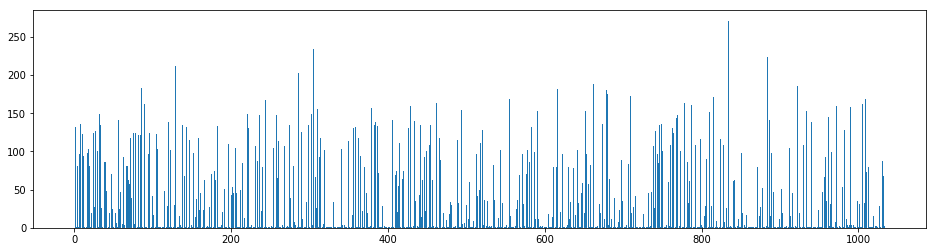

In [6]:
# print(json.dumps(genomes, indent=2))
# print(genomes)
# print(genes)
fig, ax = plt.subplots(figsize=(16, 4))
_ = ax.bar(np.arange(len(genomes)), list(map(lambda x: np.mean(x['fitness'][-3:]) if len(x['fitness']) > 0 else 0, genomes)))

In [52]:
# Setup the environment
env_size = (54,18)
env = np.zeros((env_size[0], env_size[1], len(env_p))).astype(np.float32)
ground_level = env_size[1] // 3
# Earth starts full of nutrients
env[:, :ground_level, env_p_map['aminoacids']] = 1.0

# Setup the initial cells
batch_size = 4
cells = np.zeros((batch_size, len(cell_p))).astype(np.float32)
best_genomes = np.argsort(list(map(lambda x: np.mean(x['fitness'][-3:]) if len(x['fitness']) > 2 else 0, genomes)))[::-1]
best_genomes = [0] * batch_size
# Sample new genomes
for i in np.arange(batch_size):
  cells[i, cell_p_map['genome']] = best_genomes[i]
cells[:, cell_p_map['x']] = np.linspace(0.0, env.shape[0], cells.shape[0], endpoint=False) + float(env.shape[0]) / cells.shape[0] * 0.5
cells[:, cell_p_map['y']] = ground_level - 2
cells[:, cell_p_map['atp']] = 30.0

gene_cell_map = {}
for cell_idx, genome_id in enumerate(cells[:, cell_p_map['genome']]):
  for gene_id in genomes[int(genome_id)]['genes']:
    if gene_id not in gene_cell_map:
      gene_cell_map[gene_id] = []
    gene_cell_map[gene_id].append(cell_idx)

n_steps = 1500
sim_args = []
sim_args.append((env_p, env_p_map, cell_p, cell_p_map, resource_cost, cell2cell_diffusion, env2cell_diffusion, cell2env_diffusion, genomes, genes, gene_cell_map, cells, reactions, env, ground_level, n_steps))

result = pool.map_async(simulate, sim_args)
cell_history, env_history = result.get(timeout=600)[0]

render(cell_history, env_history)

Rendering figures..


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:24<00:00,  5.15it/s]


In [16]:
# print(len(np.unique([plt.cm.get_cmap('Set2')(x) for x in np.arange(21)])))

for i in np.arange(3):
  print(genomes[best_genomes[i]])
  print([genes[g] for g in genomes[best_genomes[i]]['genes']])
  print()

15
{'genes': [0, 0, 1, 9, 41], 'createdTime': 8, 'fitness': [153.0, 114.0, 117.0, 191.0, 177.0]}
[{'activators': [], 'repressors': [], 'product': 5}, {'activators': [], 'repressors': [], 'product': 5}, {'activators': [], 'repressors': [6], 'product': 6}, {'activators': [8], 'repressors': [], 'product': 5}, {'activators': [8], 'repressors': [], 'product': 6}]

{'genes': [0, 1, 11, 16], 'createdTime': 4, 'fitness': [140.0, 94.0, 146.0, 53.0, 148.0, 115.0, 183.0]}
[{'activators': [], 'repressors': [], 'product': 5}, {'activators': [], 'repressors': [6], 'product': 6}, {'activators': [], 'repressors': [5], 'product': 8}, {'activators': [6], 'repressors': [], 'product': 5}]

{'genes': [0, 1, 35], 'createdTime': 19, 'fitness': [182.0, 170.0, 92.0]}
[{'activators': [], 'repressors': [], 'product': 5}, {'activators': [], 'repressors': [6], 'product': 6}, {'activators': [], 'repressors': [5], 'product': 6}]



In [232]:
%load_ext line_profiler

n_steps = 1000
%lprun -f simulate simulate((env_p, env_p_map, cell_p, cell_p_map, resource_cost, cell2cell_diffusion, env2cell_diffusion, cell2env_diffusion, genomes, genes, gene_cell_map, cells, reactions, env, ground_level, n_steps))

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [59]:
frames.shape
len(cells)

66